In [ ]:
pip install nsepy

  Preparing metadata (setup.py) ... done
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36057 sha256=724319ba9279fea7bcfc4ef396989d64eda2de02e2946281dc915a2c9eac1674
  Stored in directory: /root/.cache/pip/wheels/4c/87/cb/acaf83f625e5fc73e1fe6e2a8e97680c74cd72391850ef5a86
Successfully built nsepy


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy

In [ ]:
# get daily data from yfinance
def get_daily_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    # data = nsepy.get_history(symbol=symbol, start=start, end=end)
    return data

In [ ]:
# calculate the maximum drawdown for each stock
def max_drawdown(data):
    # calculate the cumulative return
    data['cum_return'] = (1 + data['bnh_returns']).cumprod()
    # calculate the previous peak
    data['peak'] = data['cum_return'].cummax()
    # calculate the drawdown
    data['drawdown'] = data['cum_return'] / data['peak'] - 1
    # calculate the maximum drawdown
    data['max_drawdown'] = data['drawdown'].cummin()
    # return the maximum drawdown
    return data['max_drawdown']

# calculate the Bollinger Bands breakout for each stock
def bb_breakout(data, window, std):
    # calculate the 20-day moving average
    data['ma'] = data['Close'].rolling(window).mean()
    # calculate the 20-day standard deviation
    data['std'] = data['Close'].rolling(window).std()
    # calculate the upper and lower bands
    data['upper'] = data['ma'] + std * data['std']
    data['lower'] = data['ma'] - std * data['std']
    # calculate the breakout signals
    data['buy'] = np.where(data['Close'] > data['upper'], 1, 0)
    data['sell'] = np.where(data['Close'] < data['lower'], -1, 0)
    # return the breakout signals
    return data['buy'], data['sell']


In [ ]:
# Define the function to calculate the cumulative return
def get_cumulative_return(returns):
    # Calculate the cumulative product of the returns
    cumprod = (1 + returns).cumprod()
    # Return the last value of the cumulative product
    return cumprod.iloc[-1]

In [ ]:
# Define the function to calculate the annualized sharpe ratio
def get_annualized_sharpe_ratio(returns):
    # Calculate the annualized return
    annualized_return = (1 + returns).cumprod().iloc[-1] ** (252 / len(returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    # Calculate the sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    # Return the sharpe ratio
    return sharpe_ratio


In [ ]:
# backtesting parameters
days = 2000
end = dt.today()
start = end - pd.Timedelta(days=days)

# portfolio of stocks
portfolio_stocks = ["COST","AMZN","GOOG","AXP","MSFT","MMM"]

# defining a data frame to store portfolio returns
portfolio_strategy_returns = pd.DataFrame()
portfolio_bnh_returns = pd.DataFrame()

# buy and hold returns for individual stocs
bnh_stock_returns = []
bnh_stock_sharpe = []

# iterating over stocks in the portfolio
for stock in portfolio_stocks:
    data = get_daily_data(stock, start, end)

    # Calcuulating daily returns
    data["bnh_returns"] = np.log(data["Close"]/data["Close"].shift())

    # Calculating maximum drawdown
    data['max_drawdown'] = max_drawdown(data)

    # Calculating Bollinger Bands breakout
    data['buy'], data['sell'] = bb_breakout(data, window=20, std=2)

    # Defining the risk-reward ratio
    rr = 2

    # Calculating the mean return
    data['mean_return'] = data['bnh_returns'].rolling(20).mean()

    # Defining the exit signal based on the maximum drawdown and the risk-reward ratio
    data['exit'] = np.where(data['max_drawdown'] < -rr * data['mean_return'], -1, 0)

    # Combining the buy, sell, and exit signals
    data['signal'] = data['buy'] + data['sell'] + data['exit']

    # Calculating the strategy returns
    data['strategy_returns'] = data['bnh_returns'] * data['signal']

    # Storing the strategy returns in the portfolio data frame
    portfolio_strategy_returns[stock] = data['strategy_returns']

    # Calculating the cumulative and annualized sharpe ratio for each stock
    bnh_stock_returns.append(get_cumulative_return(data['strategy_returns']))
    bnh_stock_sharpe.append(get_annualized_sharpe_ratio(data['strategy_returns']))

    # Creating a performance data frame
    perf = pd.DataFrame(index=portfolio_stocks,columns=["Cumulative returns","Annualized Sharpe Ratio"])

# Assigning the performance metrics to the data frame
for i,stock in enumerate(portfolio_stocks):
    cum_ret = bnh_stock_returns[i]
    anu_shp = bnh_stock_sharpe[i]
    perf.loc[stock] = [cum_ret,anu_shp]

# Printing the performance data frame
print(perf)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


     Cumulative returns Annualized Sharpe Ratio
COST           3.152325                0.828946
AMZN          20.994502                1.816934
GOOG           8.674663                1.317215
AXP           13.620421                1.485803
MSFT           4.027526                0.804738
MMM           25.000636                2.194169


Cumulative returns BB Blackout                 : 10.661806109917016
Annualized sharpe ratio BB Strategy             : 1.8407996978457268




<Axes: title={'center': 'BB Blackout STRATEGY CUMULATIVE RETURNS'}, xlabel='Date'>

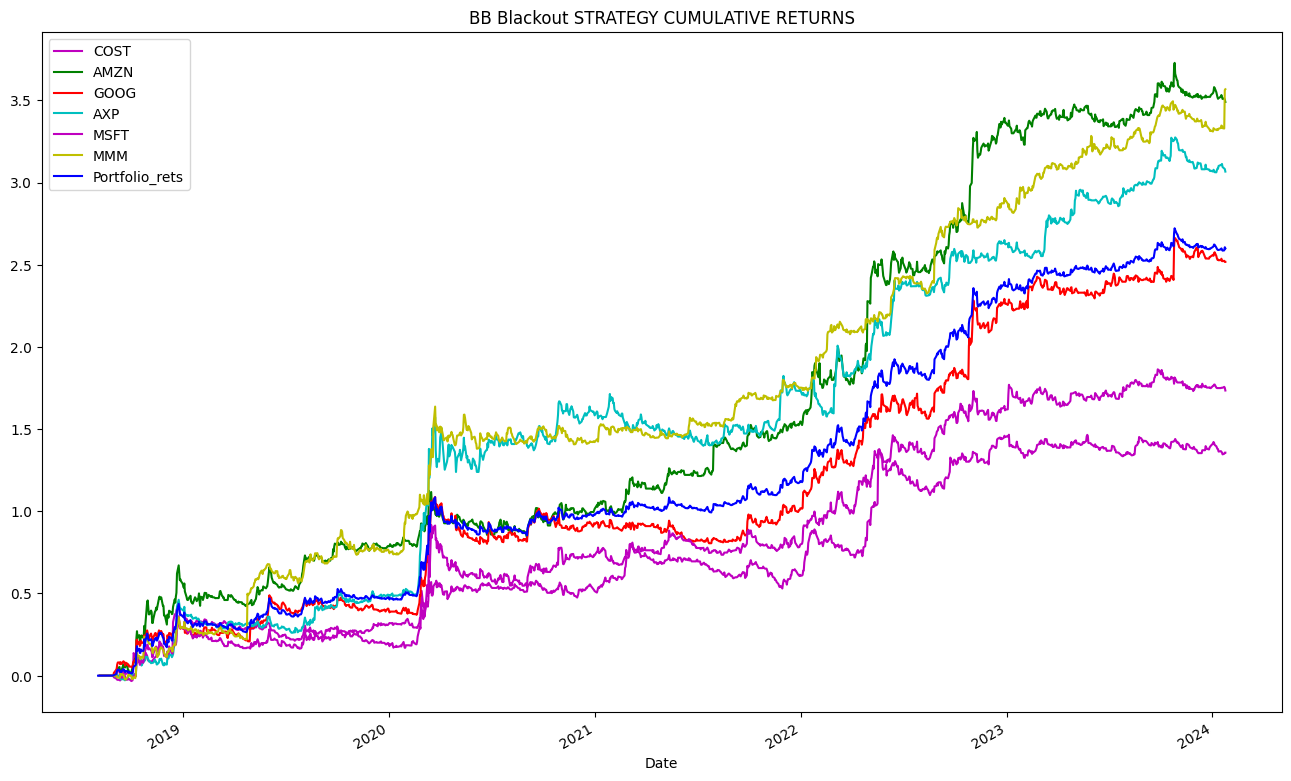

In [ ]:
# Define the weights for each stock
weights = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1]

# Multiply the returns by the weights and sum them along the columns
portfolio_strategy_returns['Portfolio_rets'] = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)

# Printing the portfolio performance metrics
print("Cumulative returns BB Blackout                 :",get_cumulative_return(portfolio_strategy_returns["Portfolio_rets"]))
print("Annualized sharpe ratio BB Strategy             :",get_annualized_sharpe_ratio(portfolio_strategy_returns["Portfolio_rets"]))
print("\n")

# Plotting the portfolio cumulative returns
colors = ['m', 'g', 'r', 'c', 'm', 'y', 'b']
portfolio_strategy_returns.cumsum().plot(figsize=(16,10), title="BB Blackout STRATEGY CUMULATIVE RETURNS", color=colors)

In [ ]:
# Define the objective function as the negative of the annualized Sharpe ratio
def objective_function(weights):
    # Calculate the portfolio returns
    portfolio_returns = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)
    # Calculate the negative of the annualized Sharpe ratio
    neg_sharpe = -get_annualized_sharpe_ratio(portfolio_returns)
    # Return the negative of the annualized Sharpe ratio
    return neg_sharpe

# Define the gradient of the objective function
def gradient(weights):
    # Calculate the portfolio returns
    portfolio_returns = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)
    # Calculate the annualized return
    annualized_return = (1 + portfolio_returns).cumprod().iloc[-1] ** (252 / len(portfolio_returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = portfolio_returns.std() * (252 ** 0.5)
    # Calculate the gradient of the annualized return
    grad_return = portfolio_strategy_returns.mean() * 252
    # Calculate the gradient of the annualized volatility
    grad_volatility = portfolio_strategy_returns.cov() @ weights * (252 ** 0.5)
    # Calculate the gradient of the Sharpe ratio
    grad_sharpe = (grad_return / annualized_volatility) - (annualized_return / annualized_volatility ** 2) * grad_volatility
    # Return the negative of the gradient of the Sharpe ratio
    return -grad_sharpe

Iteration 1: Objective function value = -1.8615
Iteration 2: Objective function value = -1.8717
Iteration 3: Objective function value = -1.9051
Iteration 4: Objective function value = -1.9349
Iteration 5: Objective function value = -1.9615
Iteration 6: Objective function value = -1.9851
Iteration 7: Objective function value = -2.0062
Iteration 8: Objective function value = -2.0250
Iteration 9: Objective function value = -2.0417
Iteration 10: Objective function value = -2.0565
Iteration 11: Objective function value = -2.0698
Iteration 12: Objective function value = -2.0815
Iteration 13: Objective function value = -2.0920
Iteration 14: Objective function value = -2.1014
Iteration 15: Objective function value = -2.1097
Iteration 16: Objective function value = -2.1172
Iteration 17: Objective function value = -2.1238
Iteration 18: Objective function value = -2.1297
Iteration 19: Objective function value = -2.1350
Iteration 20: Objective function value = -2.1397
Iteration 21: Objective funct

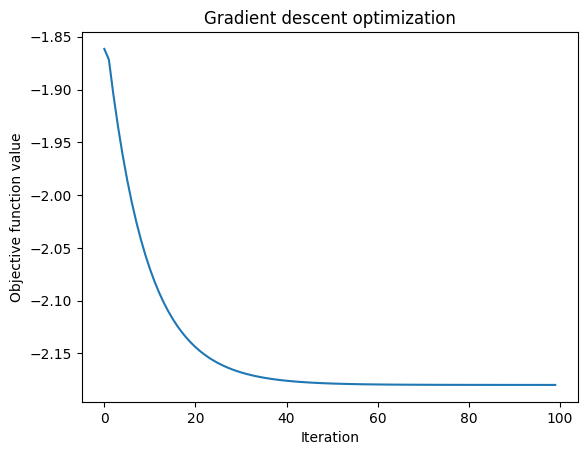

In [ ]:
# Define the learning rate
alpha = 0.01

# Define the initial weights
weights = np.array([0.1, 0.2, 0.3, 0.1, 0.2, 0.1, 0.1])

# Define the number of iterations
iterations = 100

# Define a list to store the objective function values
obj_values = []

# Loop over the iterations
for i in range(iterations):
    # Calculate the objective function value
    obj_value = objective_function(weights)
    # Append the objective function value to the list
    obj_values.append(obj_value)
    # Print the iteration number and the objective function value
    print(f"Iteration {i+1}: Objective function value = {obj_value:.4f}")
    # Calculate the gradient
    grad = gradient(weights)
    # Update the weights using the gradient and the learning rate
    weights = weights - alpha * grad
    # Apply the box constraint to the weights
    weights = np.clip(weights, 0, 1)
    # Apply the budget constraint to the weights
    weights = weights / weights.sum()

# Print the optimal weights
print(f"Optimal weights: {weights}")

# Plot the objective function values
import matplotlib.pyplot as plt
plt.plot(obj_values)
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.title("Gradient descent optimization")
plt.show()

Iteration 1: Objective function value = 0.8251
Iteration 2: Objective function value = 0.8158
Iteration 3: Objective function value = 0.8048
Iteration 4: Objective function value = 0.7931
Iteration 5: Objective function value = 0.7808
Iteration 6: Objective function value = 0.7679
Iteration 7: Objective function value = 0.7542
Iteration 8: Objective function value = 0.7399
Iteration 9: Objective function value = 0.7248
Iteration 10: Objective function value = 0.7090
Iteration 11: Objective function value = 0.6925
Iteration 12: Objective function value = 0.6805
Iteration 13: Objective function value = 0.6699
Iteration 14: Objective function value = 0.6587
Iteration 15: Objective function value = 0.6488
Iteration 16: Objective function value = 0.6405
Iteration 17: Objective function value = 0.6319
Iteration 18: Objective function value = 0.6229
Iteration 19: Objective function value = 0.6142
Iteration 20: Objective function value = 0.6062
Iteration 21: Objective function value = 0.5978
I

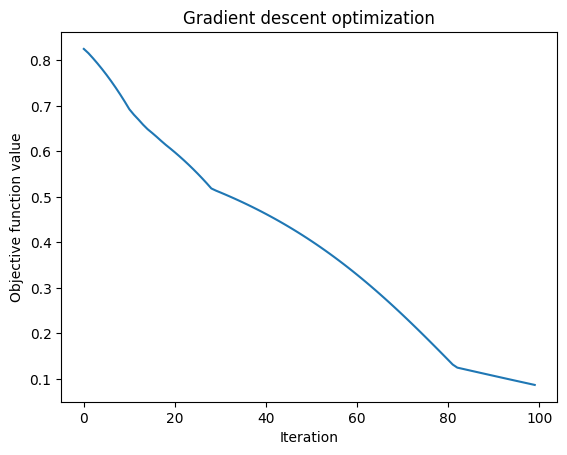

In [ ]:
# Define the learning rate
alpha = 0.01

# Define the initial weights
weights = np.array([0.1, 0.2, 0.3, 0.1, 0.2, 0.1, 0.1])

# Define the number of iterations
iterations = 100

# Define a list to store the objective function values
obj_values = []

# Loop over the iterations
for i in range(iterations):
    # Calculate the objective function value
    obj_value = objective_function(weights)
    # Append the objective function value to the list
    obj_values.append(obj_value)
    # Print the iteration number and the objective function value
    print(f"Iteration {i+1}: Objective function value = {obj_value:.4f}")
    # Calculate the gradient
    grad = gradient(weights)
    # Update the weights using the gradient and the learning rate
    weights = weights - alpha * grad
    # Apply the box constraint to the weights
    weights = np.clip(weights, 0, 1)
    # Apply the budget constraint to the weights
    weights = weights / weights.sum()

# Print the optimal weights
print(f"Optimal weights: {weights}")

# Plot the objective function values
import matplotlib.pyplot as plt
plt.plot(obj_values)
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.title("Gradient descent optimization")
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy


In [ ]:
# get daily data from yfinance
def get_daily_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    # data = nsepy.get_history(symbol=symbol, start=start, end=end)
    return data

# calculate the maximum drawdown for each stock
def max_drawdown(data):
    # calculate the cumulative return
    data['cum_return'] = (1 + data['bnh_returns']).cumprod()
    # calculate the previous peak
    data['peak'] = data['cum_return'].cummax()
    # calculate the drawdown
    data['drawdown'] = data['cum_return'] / data['peak'] - 1
    # calculate the maximum drawdown
    data['max_drawdown'] = data['drawdown'].cummin()
    # return the maximum drawdown
    return data['max_drawdown']

# calculate the RSI divergence for each stock
def rsi_divergence(data, period, fast, slow):
    # calculate the difference between the closing prices of consecutive days
    delta = data['Close'].diff()
    # separate the positive and negative differences
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    # calculate the exponential moving average of the positive and negative differences
    up_ema = up.ewm(com=period-1, adjust=False).mean()
    down_ema = down.ewm(com=period-1, adjust=False).mean()
    # calculate the relative strength as the ratio of the positive and negative averages
    rs = up_ema / down_ema
    # calculate the RSI as 100 minus 100 divided by 1 plus the relative strength
    rsi = 100 - (100 / (1 + rs))
    # calculate the fast and slow RSI
    rsi_fast = rsi.rolling(fast).mean()
    rsi_slow = rsi.rolling(slow).mean()
    # calculate the divergence as the difference between the fast and slow RSI
    divergence = rsi_fast - rsi_slow
    # calculate the buy and sell signals based on the RSI divergence
    data['buy'] = np.where((rsi < 30) & (divergence > divergence.shift()), 1, 0)
    data['sell'] = np.where((rsi > 70) & (divergence < divergence.shift()), -1, 0)
    # return the buy and sell signals
    return data['buy'], data['sell']

#Define the function to calculate the cumulative return
def get_cumulative_return(returns):
    # Calculate the cumulative product of the returns
    cumprod = (1 + returns).cumprod()
    # Return the last value of the cumulative product
    return cumprod.iloc[-1]

# Define the function to calculate the annualized sharpe ratio
def get_annualized_sharpe_ratio(returns):
    # Calculate the annualized return
    annualized_return = (1 + returns).cumprod().iloc[-1] ** (252 / len(returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    # Calculate the sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    # Return the sharpe ratio
    return sharpe_ratio


In [ ]:
# backtesting parameters
days = 2000
end = dt.today()
start = end - pd.Timedelta(days=days)

# portfolio of stocks
portfolio_stocks = ["COST","AMZN","GOOG","AXP","MSFT","MMM"]

# defining a data frame to store portfolio returns
portfolio_strategy_returns = pd.DataFrame()
portfolio_bnh_returns = pd.DataFrame()

# buy and hold returns for individual stocs
bnh_stock_returns = []
bnh_stock_sharpe = []

# iterating over stocks in the portfolio
for stock in portfolio_stocks:
    data = get_daily_data(stock, start, end)

    # Calcuulating daily returns
    data["bnh_returns"] = np.log(data["Close"]/data["Close"].shift())

    # Calculating maximum drawdown
    data['max_drawdown'] = max_drawdown(data)

    # Calculating RSI divergence
    data['buy'], data['sell'] = rsi_divergence(data, period=14, fast=5, slow=14)

    # Defining the risk-reward ratio
    rr = 2

    # Calculating the mean return
    data['mean_return'] = data['bnh_returns'].rolling(20).mean()

    # Defining the exit signal based on the maximum drawdown and the risk-reward ratio
    data['exit'] = np.where(data['max_drawdown'] < -rr * data['mean_return'], -1, 0)

    # Combining the buy, sell, and exit signals
    data['signal'] = data['buy'] + data['sell'] + data['exit']

    # Calculating the strategy returns
    data['strategy_returns'] = data['bnh_returns'] * data['signal']

    # Storing the strategy returns in the portfolio data frame
    portfolio_strategy_returns[stock] = data['strategy_returns']

    # Calculating the cumulative and annualized sharpe ratio for each stock
    bnh_stock_returns.append(get_cumulative_return(data['strategy_returns']))
    bnh_stock_sharpe.append(get_annualized_sharpe_ratio(data['strategy_returns']))

    # Creating a performance data frame
    perf = pd.DataFrame(index=portfolio_stocks,columns=["Cumulative returns","Annualized Sharpe Ratio"])


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Assigning the performance metrics to the data frame
for i,stock in enumerate(portfolio_stocks):
    cum_ret = bnh_stock_returns[i]
    anu_shp = bnh_stock_sharpe[i]
    perf.loc[stock] = [cum_ret,anu_shp]

# Printing the performance data frame
print(perf)
# Define the weights for each stock
weights = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1]

# Multiply the returns by the weights and sum them along the columns
portfolio_strategy_returns['Portfolio_rets'] = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)

# Printing the portfolio performance metrics
print("Cumulative returns RSI Divergence                 :",get_cumulative_return(portfolio_strategy_returns["Portfolio_rets"]))
print("Annualized sharpe ratio RSI Divergence             :",get_annualized_sharpe_ratio(portfolio_strategy_returns["Portfolio_rets"]))
print("\n")

     Cumulative returns Annualized Sharpe Ratio
COST           0.174096               -1.151809
AMZN           0.366482               -0.464217
GOOG            0.21337               -0.771858
AXP            0.188599               -0.730607
MSFT           0.154681               -0.935752
MMM            0.990578               -0.006183
Cumulative returns RSI Divergence                 : 0.27979451091027624
Annualized sharpe ratio RSI Divergence             : -0.8244384770190577




<Axes: title={'center': 'RSI Divergence STRATEGY CUMULATIVE RETURNS'}, xlabel='Date'>

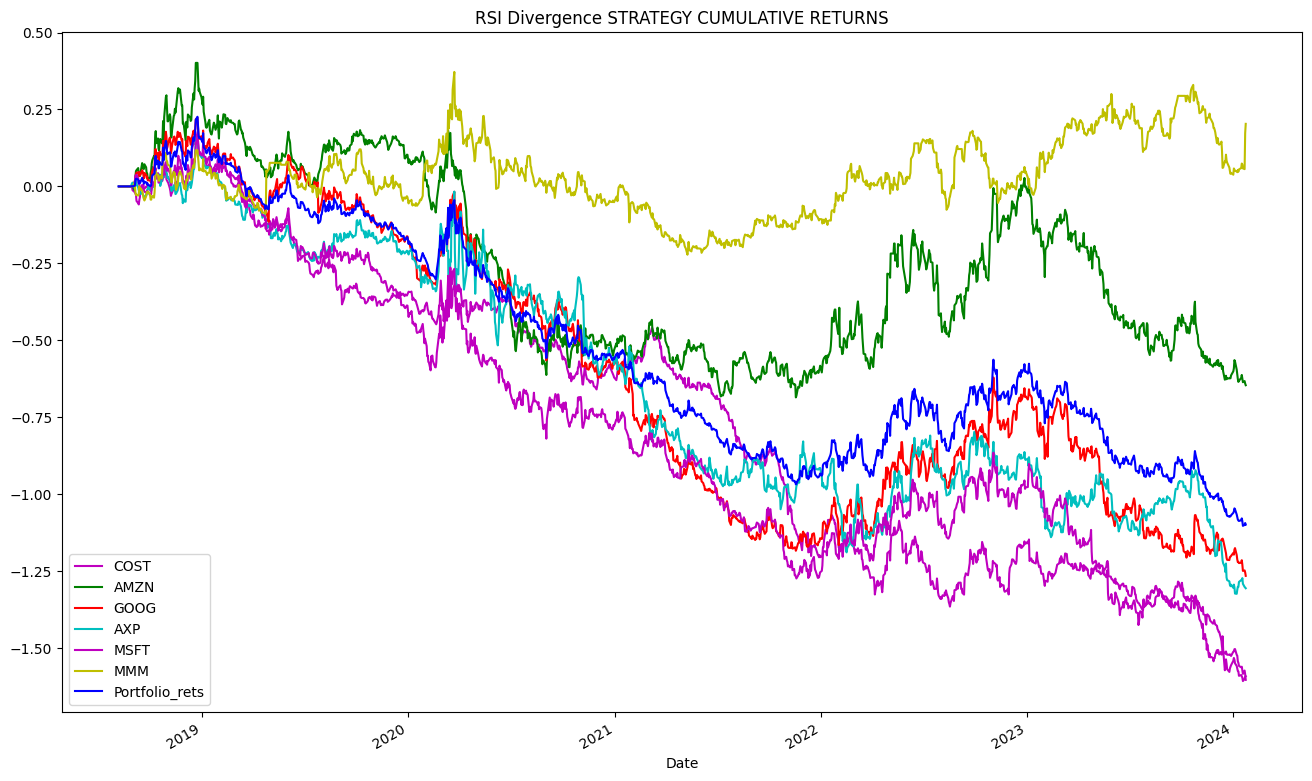

In [ ]:
# Plotting the portfolio cumulative returns
colors = ['m', 'g', 'r', 'c', 'm', 'y', 'b']
portfolio_strategy_returns.cumsum().plot(figsize=(16,10), title="RSI Divergence STRATEGY CUMULATIVE RETURNS", color=colors)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy


In [ ]:
# get daily data from yfinance
def get_daily_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    # data = nsepy.get_history(symbol=symbol, start=start, end=end)
    return data

# calculate the maximum drawdown for each stock
def max_drawdown(data):
    # calculate the cumulative return
    data['cum_return'] = (1 + data['bnh_returns']).cumprod()
    # calculate the previous peak
    data['peak'] = data['cum_return'].cummax()
    # calculate the drawdown
    data['drawdown'] = data['cum_return'] / data['peak'] - 1
    # calculate the maximum drawdown
    data['max_drawdown'] = data['drawdown'].cummin()
    # return the maximum drawdown
    return data['max_drawdown']

# define a function to calculate the exponential moving average of a series
def ema(series, period):
    # use the pandas ewm function with adjust=False
    return series.ewm(span=period, adjust=False).mean()

# calculate the MACD histogram for each stock
def macd_histogram(data, fast, slow, signal):
    # calculate the 12-day, 26-day, and 9-day exponential moving averages of the closing prices
    ema_fast = ema(data['Close'], fast)
    ema_slow = ema(data['Close'], slow)
    ema_signal = ema(data['Close'], signal)
    # calculate the MACD line as the difference between the 12-day and 26-day exponential moving averages
    data['macd'] = ema_fast - ema_slow
    # calculate the signal line as the 9-day exponential moving average of the MACD line
    data['signal'] = ema(data['macd'], signal)
    # calculate the histogram as the difference between the MACD line and the signal line
    data['histogram'] = data['macd'] - data['signal']
    # calculate the buy and sell signals based on the MACD histogram
    data['buy'] = np.where((data['histogram'] > 0) & (data['histogram'] > data['histogram'].shift()), 1, 0)
    data['sell'] = np.where((data['histogram'] < 0) & (data['histogram'] < data['histogram'].shift()), -1, 0)
    # return the buy and sell signals
    return data['buy'], data['sell']

#Define the function to calculate the cumulative return
def get_cumulative_return(returns):
    # Calculate the cumulative product of the returns
    cumprod = (1 + returns).cumprod()
    # Return the last value of the cumulative product
    return cumprod.iloc[-1]

# Define the function to calculate the annualized sharpe ratio
def get_annualized_sharpe_ratio(returns):
    # Calculate the annualized return
    annualized_return = (1 + returns).cumprod().iloc[-1] ** (252 / len(returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    # Calculate the sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    # Return the sharpe ratio
    return sharpe_ratio


In [ ]:
# backtesting parameters
days = 2000
end = dt.today()
start = end - pd.Timedelta(days=days)

# portfolio of stocks
portfolio_stocks = ["COST","AMZN","GOOG","AXP","MSFT","MMM"]

# defining a data frame to store portfolio returns
portfolio_strategy_returns = pd.DataFrame()
portfolio_bnh_returns = pd.DataFrame()

# buy and hold returns for individual stocs
bnh_stock_returns = []
bnh_stock_sharpe = []

# iterating over stocks in the portfolio
for stock in portfolio_stocks:
    data = get_daily_data(stock, start, end)

    # Calcuulating daily returns
    data["bnh_returns"] = np.log(data["Close"]/data["Close"].shift())

    # Calculating maximum drawdown
    data['max_drawdown'] = max_drawdown(data)

    # Calculating MACD histogram
    data['buy'], data['sell'] = macd_histogram(data, fast=12, slow=26, signal=9)

    # Defining the risk-reward ratio
    rr = 2

    # Calculating the mean return
    data['mean_return'] = data['bnh_returns'].rolling(20).mean()

    # Defining the exit signal based on the maximum drawdown and the risk-reward ratio
    data['exit'] = np.where(data['max_drawdown'] < -rr * data['mean_return'], -1, 0)

    # Combining the buy, sell, and exit signals
    data['signal'] = data['buy'] + data['sell'] + data['exit']

    # Calculating the strategy returns
    data['strategy_returns'] = data['bnh_returns'] * data['signal']

    # Storing the strategy returns in the portfolio data frame
    portfolio_strategy_returns[stock] = data['strategy_returns']

    # Calculating the cumulative and annualized sharpe ratio for each stock
    bnh_stock_returns.append(get_cumulative_return(data['strategy_returns']))
    bnh_stock_sharpe.append(get_annualized_sharpe_ratio(data['strategy_returns']))

    # Creating a performance data frame
    perf = pd.DataFrame(index=portfolio_stocks,columns=["Cumulative returns","Annualized Sharpe Ratio"])


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Assigning the performance metrics to the data frame
for i,stock in enumerate(portfolio_stocks):
    cum_ret = bnh_stock_returns[i]
    anu_shp = bnh_stock_sharpe[i]
    perf.loc[stock] = [cum_ret,anu_shp]

# Printing the performance data frame
print(perf)
# Define the weights for each stock
weights = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1]

# Multiply the returns by the weights and sum them along the columns
portfolio_strategy_returns['Portfolio_rets'] = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)

# Printing the portfolio performance metrics
print("Cumulative returns MACD Histogram                 :",get_cumulative_return(portfolio_strategy_returns["Portfolio_rets"]))
print("Annualized sharpe ratio MACD Histogram             :",get_annualized_sharpe_ratio(portfolio_strategy_returns["Portfolio_rets"]))
print("\n")

     Cumulative returns Annualized Sharpe Ratio
COST         219.704943                5.235528
AMZN        8166.854809                9.163545
GOOG        1432.954636                7.002332
AXP         3211.682142                7.295134
MSFT         860.347815                6.223455
MMM          2984.11488                8.773327
Cumulative returns MACD Histogram                 : 2083.738010813258
Annualized sharpe ratio MACD Histogram             : 9.503210614007351




<Axes: title={'center': 'MACD Histogram STRATEGY CUMULATIVE RETURNS'}, xlabel='Date'>

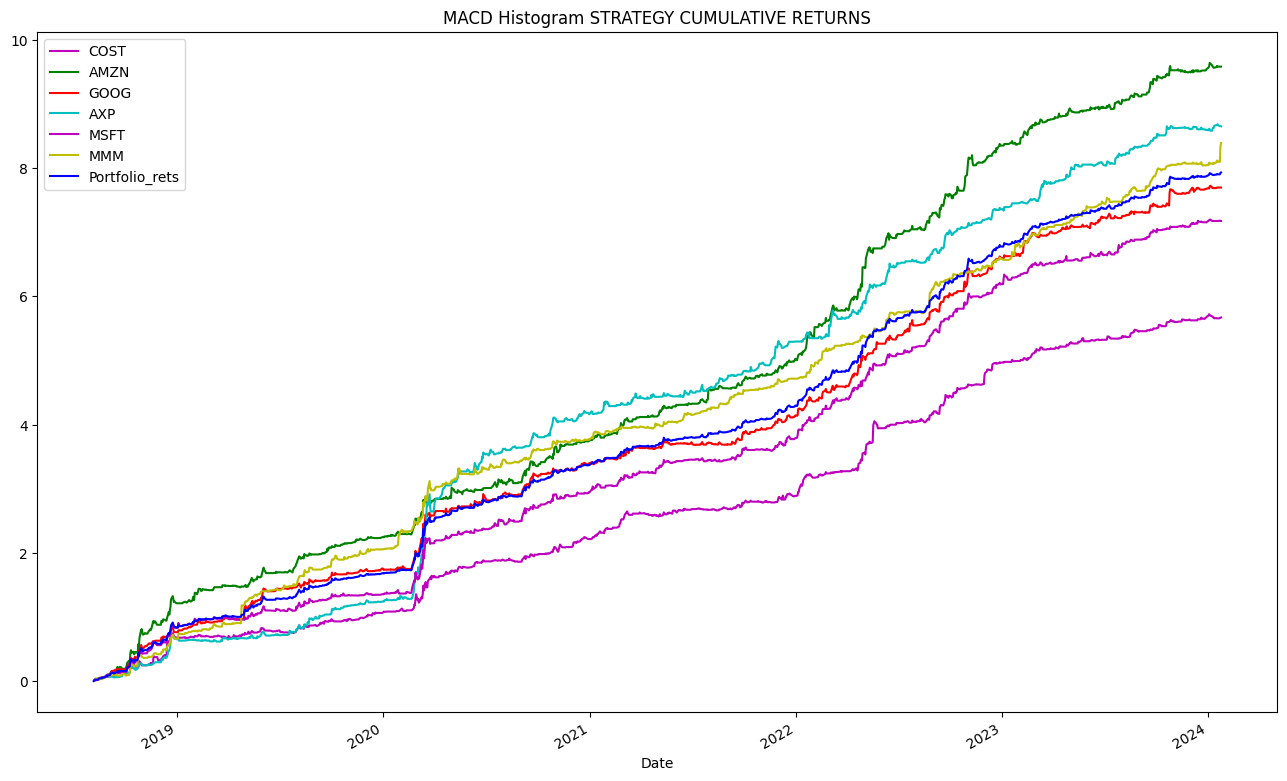

In [ ]:
# Plotting the portfolio cumulative returns
colors = ['m', 'g', 'r', 'c', 'm', 'y', 'b']
portfolio_strategy_returns.cumsum().plot(figsize=(16,10), title="MACD Histogram STRATEGY CUMULATIVE RETURNS", color=colors)

In [ ]:
# Define the objective function as the negative of the annualized Sharpe ratio
def objective_function(weights):
    # Calculate the portfolio returns
    portfolio_returns = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)
    # Calculate the negative of the annualized Sharpe ratio
    neg_sharpe = -get_annualized_sharpe_ratio(portfolio_returns)
    # Return the negative of the annualized Sharpe ratio
    return neg_sharpe

# Define the gradient of the objective function
def gradient(weights):
    # Calculate the portfolio returns
    portfolio_returns = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)
    # Calculate the annualized return
    annualized_return = (1 + portfolio_returns).cumprod().iloc[-1] ** (252 / len(portfolio_returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = portfolio_returns.std() * (252 ** 0.5)
    # Calculate the gradient of the annualized return
    grad_return = portfolio_strategy_returns.mean() * 252
    # Calculate the gradient of the annualized volatility
    grad_volatility = portfolio_strategy_returns.cov() @ weights * (252 ** 0.5)
    # Calculate the gradient of the Sharpe ratio
    grad_sharpe = (grad_return / annualized_volatility) - (annualized_return / annualized_volatility ** 2) * grad_volatility
    # Return the negative of the gradient of the Sharpe ratio
    return -grad_sharpe

Iteration 1: Objective function value = -10.2876
Iteration 2: Objective function value = -9.6573
Iteration 3: Objective function value = -9.7947
Iteration 4: Objective function value = -9.8955
Iteration 5: Objective function value = -9.9696
Iteration 6: Objective function value = -10.0242
Iteration 7: Objective function value = -10.0648
Iteration 8: Objective function value = -10.0950
Iteration 9: Objective function value = -10.1176
Iteration 10: Objective function value = -10.1346
Iteration 11: Objective function value = -10.1473
Iteration 12: Objective function value = -10.1570
Iteration 13: Objective function value = -10.1642
Iteration 14: Objective function value = -10.1697
Iteration 15: Objective function value = -10.1739
Iteration 16: Objective function value = -10.1771
Iteration 17: Objective function value = -10.1795
Iteration 18: Objective function value = -10.1813
Iteration 19: Objective function value = -10.1827
Iteration 20: Objective function value = -10.1837
Iteration 21:

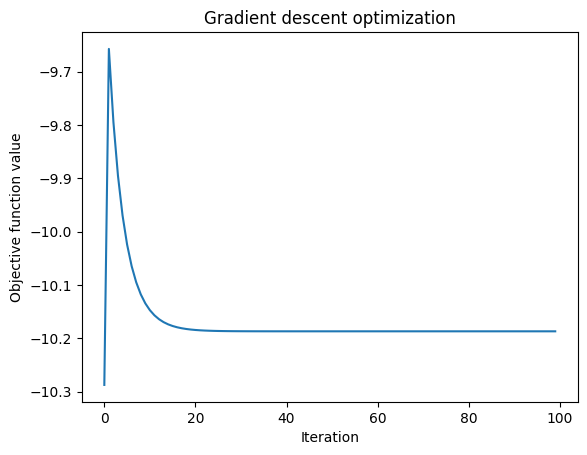

In [ ]:
# Define the learning rate
alpha = 0.01

# Define the initial weights
weights = np.array([0.1, 0.2, 0.3, 0.1, 0.2, 0.1, 0.1])

# Define the number of iterations
iterations = 100

# Define a list to store the objective function values
obj_values = []

# Loop over the iterations
for i in range(iterations):
    # Calculate the objective function value
    obj_value = objective_function(weights)
    # Append the objective function value to the list
    obj_values.append(obj_value)
    # Print the iteration number and the objective function value
    print(f"Iteration {i+1}: Objective function value = {obj_value:.4f}")
    # Calculate the gradient
    grad = gradient(weights)
    # Update the weights using the gradient and the learning rate
    weights = weights - alpha * grad
    # Apply the box constraint to the weights
    weights = np.clip(weights, 0, 1)
    # Apply the budget constraint to the weights
    weights = weights / weights.sum()

# Print the optimal weights
print(f"Optimal weights: {weights}")

# Plot the objective function values
import matplotlib.pyplot as plt
plt.plot(obj_values)
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.title("Gradient descent optimization")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy


In [ ]:
# get daily data from yfinance
def get_daily_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    # data = nsepy.get_history(symbol=symbol, start=start, end=end)
    return data

# calculate the maximum drawdown for each stock
def max_drawdown(data):
    # calculate the cumulative return
    data['cum_return'] = (1 + data['bnh_returns']).cumprod()
    # calculate the previous peak
    data['peak'] = data['cum_return'].cummax()
    # calculate the drawdown
    data['drawdown'] = data['cum_return'] / data['peak'] - 1
    # calculate the maximum drawdown
    data['max_drawdown'] = data['drawdown'].cummin()
    # return the maximum drawdown
    return data['max_drawdown']

# calculate the stochastic oscillator for each stock
def get_stoch(high, low, close):
    # calculate the highest high and lowest low over a 14-day period
    highest_high = high.rolling(14).max()
    lowest_low = low.rolling(14).min()
    # calculate the fast stochastic line
    stoch_fast = (close - lowest_low) / (highest_high - lowest_low) * 100
    # calculate the slow stochastic line as the 3-day simple moving average of the fast line
    stoch_slow = stoch_fast.rolling(3).mean()
    # return the fast and slow stochastic lines
    return stoch_fast, stoch_slow

#Define the function to calculate the cumulative return
def get_cumulative_return(returns):
    # Calculate the cumulative product of the returns
    cumprod = (1 + returns).cumprod()
    # Return the last value of the cumulative product
    return cumprod.iloc[-1]

# Define the function to calculate the annualized sharpe ratio
def get_annualized_sharpe_ratio(returns):
    # Calculate the annualized return
    annualized_return = (1 + returns).cumprod().iloc[-1] ** (252 / len(returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    # Calculate the sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    # Return the sharpe ratio
    return sharpe_ratio


In [ ]:
# backtesting parameters
days = 2000
end = dt.today()
start = end - pd.Timedelta(days=days)

# portfolio of stocks
portfolio_stocks = ["COST","AMZN","GOOG","AXP","MSFT","MMM"]

# defining a data frame to store portfolio returns
portfolio_strategy_returns = pd.DataFrame()
portfolio_bnh_returns = pd.DataFrame()

# buy and hold returns for individual stocs
bnh_stock_returns = []
bnh_stock_sharpe = []

# iterating over stocks in the portfolio
for stock in portfolio_stocks:
    data = get_daily_data(stock, start, end)

    # Calcuulating daily returns
    data["bnh_returns"] = np.log(data["Close"]/data["Close"].shift())

    # Calculating maximum drawdown
    data['max_drawdown'] = max_drawdown(data)

    # Calculating stochastic oscillator
    data['stoch_fast'], data['stoch_slow'] = get_stoch(data['High'], data['Low'], data['Close'])

    # Defining the risk-reward ratio
    rr = 2

    # Calculating the mean return
    data['mean_return'] = data['bnh_returns'].rolling(20).mean()

    # Defining the exit signal based on the maximum drawdown and the risk-reward ratio
    data['exit'] = np.where(data['max_drawdown'] < -rr * data['mean_return'], -1, 0)

    # Calculating the buy and sell signals based on the stochastic oscillator
    data['buy'] = np.where((data['stoch_slow'] > data['stoch_fast']) & (data['stoch_slow'].shift() < data['stoch_fast'].shift()), 1, 0)
    data['sell'] = np.where((data['stoch_slow'] < data['stoch_fast']) & (data['stoch_slow'].shift() > data['stoch_fast'].shift()), -1, 0)

    # Combining the buy, sell, and exit signals
    data['signal'] = data['buy'] + data['sell'] + data['exit']

    # Calculating the strategy returns
    data['strategy_returns'] = data['bnh_returns'] * data['signal']

    # Storing the strategy returns in the portfolio data frame
    portfolio_strategy_returns[stock] = data['strategy_returns']

    # Calculating the cumulative and annualized sharpe ratio for each stock
    bnh_stock_returns.append(get_cumulative_return(data['strategy_returns']))
    bnh_stock_sharpe.append(get_annualized_sharpe_ratio(data['strategy_returns']))

    # Creating a performance data frame
    perf = pd.DataFrame(index=portfolio_stocks,columns=["Cumulative returns","Annualized Sharpe Ratio"])


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Assigning the performance metrics to the data frame
for i,stock in enumerate(portfolio_stocks):
    cum_ret = bnh_stock_returns[i]
    anu_shp = bnh_stock_sharpe[i]
    perf.loc[stock] = [cum_ret,anu_shp]

# Printing the performance data frame
print(perf)

     Cumulative returns Annualized Sharpe Ratio
COST           0.000891                 -2.4325
AMZN           0.000039               -1.996086
GOOG           0.000039               -2.245853
AXP             0.00006               -1.723631
MSFT           0.000024               -2.239971
MMM            0.001362               -2.217277


Cumulative returns Stochastic Oscillator                 : 8.709840438689231e-05
Annualized sharpe ratio Stochastic Oscillator             : -2.775526533203216




<Axes: title={'center': 'Stochastic Oscillator STRATEGY CUMULATIVE RETURNS'}, xlabel='Date'>

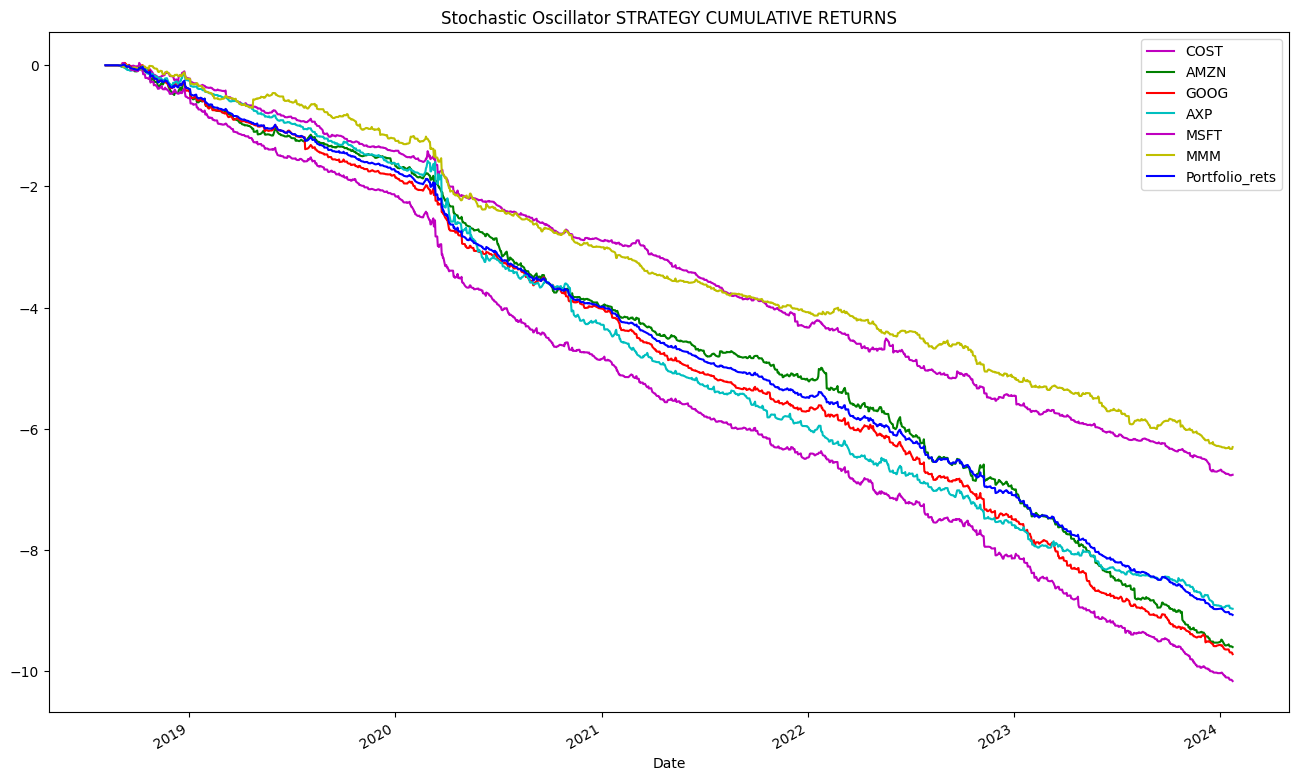

In [ ]:
# Define the weights for each stock
weights = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1]

# Multiply the returns by the weights and sum them along the columns
portfolio_strategy_returns['Portfolio_rets'] = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)

# Printing the portfolio performance metrics
print("Cumulative returns Stochastic Oscillator                 :",get_cumulative_return(portfolio_strategy_returns["Portfolio_rets"]))
print("Annualized sharpe ratio Stochastic Oscillator             :",get_annualized_sharpe_ratio(portfolio_strategy_returns["Portfolio_rets"]))
print("\n")

# Plotting the portfolio cumulative returns
colors = ['m', 'g', 'r', 'c', 'm', 'y', 'b']
portfolio_strategy_returns.cumsum().plot(figsize=(16,10), title="Stochastic Oscillator STRATEGY CUMULATIVE RETURNS", color=colors)

In [ ]:
# Define the objective function as the negative of the annualized Sharpe ratio
def objective_function(weights):
    # Calculate the portfolio returns
    portfolio_returns = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)
    # Calculate the negative of the annualized Sharpe ratio
    neg_sharpe = -get_annualized_sharpe_ratio(portfolio_returns)
    # Return the negative of the annualized Sharpe ratio
    return neg_sharpe

# Define the gradient of the objective function
def gradient(weights):
    # Calculate the portfolio returns
    portfolio_returns = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)
    # Calculate the annualized return
    annualized_return = (1 + portfolio_returns).cumprod().iloc[-1] ** (252 / len(portfolio_returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = portfolio_returns.std() * (252 ** 0.5)
    # Calculate the gradient of the annualized return
    grad_return = portfolio_strategy_returns.mean() * 252
    # Calculate the gradient of the annualized volatility
    grad_volatility = portfolio_strategy_returns.cov() @ weights * (252 ** 0.5)
    # Calculate the gradient of the Sharpe ratio
    grad_sharpe = (grad_return / annualized_volatility) - (annualized_return / annualized_volatility ** 2) * grad_volatility
    # Return the negative of the gradient of the Sharpe ratio
    return -grad_sharpe

Iteration 1: Objective function value = 2.6134
Iteration 2: Objective function value = 2.7419
Iteration 3: Objective function value = 2.6627
Iteration 4: Objective function value = 2.5744
Iteration 5: Objective function value = 2.4849
Iteration 6: Objective function value = 2.4425
Iteration 7: Objective function value = 2.4199
Iteration 8: Objective function value = 2.3881
Iteration 9: Objective function value = 2.3447
Iteration 10: Objective function value = 2.3013
Iteration 11: Objective function value = 2.2698
Iteration 12: Objective function value = 2.2466
Iteration 13: Objective function value = 2.2466
Iteration 14: Objective function value = 2.2466
Iteration 15: Objective function value = 2.2466
Iteration 16: Objective function value = 2.2466
Iteration 17: Objective function value = 2.2466
Iteration 18: Objective function value = 2.2466
Iteration 19: Objective function value = 2.2466
Iteration 20: Objective function value = 2.2466
Iteration 21: Objective function value = 2.2466
I

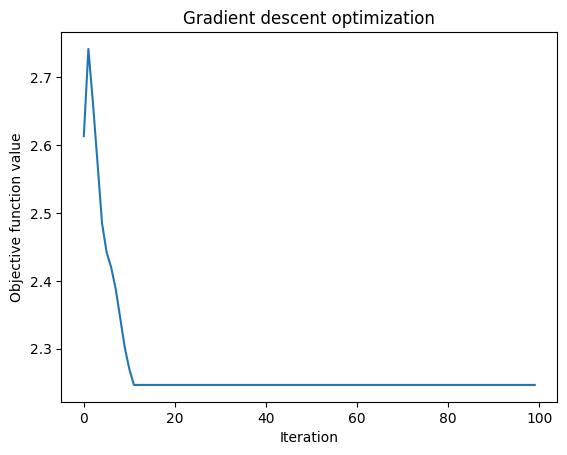

In [ ]:
# Define the learning rate
alpha = 0.01

# Define the initial weights
weights = np.array([0.1, 0.2, 0.3, 0.1, 0.2, 0.1, 0.1])

# Define the number of iterations
iterations = 100

# Define a list to store the objective function values
obj_values = []

# Loop over the iterations
for i in range(iterations):
    # Calculate the objective function value
    obj_value = objective_function(weights)
    # Append the objective function value to the list
    obj_values.append(obj_value)
    # Print the iteration number and the objective function value
    print(f"Iteration {i+1}: Objective function value = {obj_value:.4f}")
    # Calculate the gradient
    grad = gradient(weights)
    # Update the weights using the gradient and the learning rate
    weights = weights - alpha * grad
    # Apply the box constraint to the weights
    weights = np.clip(weights, 0, 1)
    # Apply the budget constraint to the weights
    weights = weights / weights.sum()

# Print the optimal weights
print(f"Optimal weights: {weights}")

# Plot the objective function values
import matplotlib.pyplot as plt
plt.plot(obj_values)
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.title("Gradient descent optimization")
plt.show()

In [ ]:
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy


In [ ]:
# get daily data from yfinance
def get_daily_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    # data = nsepy.get_history(symbol=symbol, start=start, end=end)
    return data

# calculate the maximum drawdown for each stock
def max_drawdown(data):
    # calculate the cumulative return
    data['cum_return'] = (1 + data['bnh_returns']).cumprod()
    # calculate the previous peak
    data['peak'] = data['cum_return'].cummax()
    # calculate the drawdown
    data['drawdown'] = data['cum_return'] / data['peak'] - 1
    # calculate the maximum drawdown
    data['max_drawdown'] = data['drawdown'].cummin()
    # return the maximum drawdown
    return data['max_drawdown']

# calculate the moving average crossover for each stock
def get_mac(close, short_window, long_window):
    # calculate the short-term and long-term moving averages
    ma_short = close.rolling(short_window).mean()
    ma_long = close.rolling(long_window).mean()
    # return the moving averages
    return ma_short, ma_long

#Define the function to calculate the cumulative return
def get_cumulative_return(returns):
    # Calculate the cumulative product of the returns
    cumprod = (1 + returns).cumprod()
    # Return the last value of the cumulative product
    return cumprod.iloc[-1]

# Define the function to calculate the annualized sharpe ratio
def get_annualized_sharpe_ratio(returns):
    # Calculate the annualized return
    annualized_return = (1 + returns).cumprod().iloc[-1] ** (252 / len(returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    # Calculate the sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    # Return the sharpe ratio
    return sharpe_ratio


In [ ]:
# backtesting parameters
days = 2000
end = dt.today()
start = end - pd.Timedelta(days=days)

# portfolio of stocks
portfolio_stocks = ["COST","AMZN","GOOG","AXP","MSFT","MMM"]

# defining a data frame to store portfolio returns
portfolio_strategy_returns = pd.DataFrame()
portfolio_bnh_returns = pd.DataFrame()

# buy and hold returns for individual stocs
bnh_stock_returns = []
bnh_stock_sharpe = []

# iterating over stocks in the portfolio
for stock in portfolio_stocks:
    data = get_daily_data(stock, start, end)

    # Calcuulating daily returns
    data["bnh_returns"] = np.log(data["Close"]/data["Close"].shift())

    # Calculating maximum drawdown
    data['max_drawdown'] = max_drawdown(data)

    # Calculating moving average crossover
    data['ma_short'], data['ma_long'] = get_mac(data['Close'], short_window=5, long_window=20)

    # Defining the risk-reward ratio
    rr = 2

    # Calculating the mean return
    data['mean_return'] = data['bnh_returns'].rolling(20).mean()

    # Defining the exit signal based on the maximum drawdown and the risk-reward ratio
    data['exit'] = np.where(data['max_drawdown'] < -rr * data['mean_return'], -1, 0)

    # Calculating the buy and sell signals based on the moving average crossover
    data['buy'] = np.where((data['ma_short'] > data['ma_long']) & (data['ma_short'].shift() < data['ma_long'].shift()), 1, 0)
    data['sell'] = np.where((data['ma_short'] < data['ma_long']) & (data['ma_short'].shift() > data['ma_long'].shift()), -1, 0)

    # Combining the buy, sell, and exit signals
    data['signal'] = data['buy'] + data['sell'] + data['exit']

    # Calculating the strategy returns
    data['strategy_returns'] = data['bnh_returns'] * data['signal']

    # Storing the strategy returns in the portfolio data frame
    portfolio_strategy_returns[stock] = data['strategy_returns']

    # Calculating the cumulative and annualized sharpe ratio for each stock
    bnh_stock_returns.append(get_cumulative_return(data['strategy_returns']))
    bnh_stock_sharpe.append(get_annualized_sharpe_ratio(data['strategy_returns']))

    # Creating a performance data frame
    perf = pd.DataFrame(index=portfolio_stocks,columns=["Cumulative returns","Annualized Sharpe Ratio"])


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Assigning the performance metrics to the data frame
for i,stock in enumerate(portfolio_stocks):
    cum_ret = bnh_stock_returns[i]
    anu_shp = bnh_stock_sharpe[i]
    perf.loc[stock] = [cum_ret,anu_shp]

# Printing the performance data frame
print(perf)

     Cumulative returns Annualized Sharpe Ratio
COST           0.539127                -0.43054
AMZN           1.187991                0.085522
GOOG            0.79111               -0.126688
AXP            1.244961                0.111274
MSFT           0.413994               -0.472767
MMM            3.255867                0.798997


Cumulative returns Moving Average Crossover                 : 0.9590046436252411
Annualized sharpe ratio Moving Average Crossover             : -0.02676493836084213




<Axes: title={'center': 'Moving Average Crossover STRATEGY CUMULATIVE RETURNS'}, xlabel='Date'>

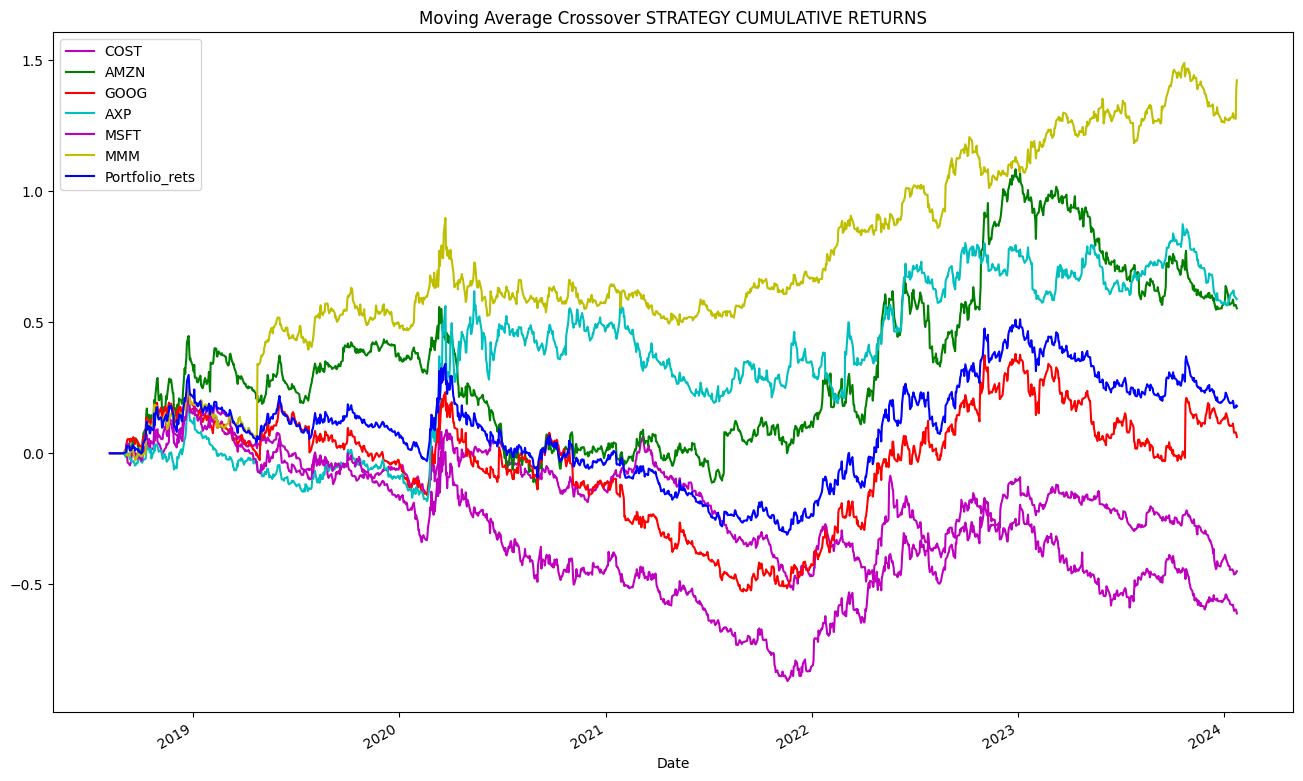

In [ ]:
# Define the weights for each stock
weights = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1,0.1]

# Multiply the returns by the weights and sum them along the columns
portfolio_strategy_returns['Portfolio_rets'] = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)

# Printing the portfolio performance metrics
print("Cumulative returns Moving Average Crossover                 :",get_cumulative_return(portfolio_strategy_returns["Portfolio_rets"]))
print("Annualized sharpe ratio Moving Average Crossover             :",get_annualized_sharpe_ratio(portfolio_strategy_returns["Portfolio_rets"]))
print("\n")

# Plotting the portfolio cumulative returns
colors = ['m', 'g', 'r', 'c', 'm', 'y', 'b']
portfolio_strategy_returns.cumsum().plot(figsize=(16,10), title="Moving Average Crossover STRATEGY CUMULATIVE RETURNS", color=colors)

In [ ]:
# Define the objective function as the negative of the annualized Sharpe ratio
def objective_function(weights):
    # Calculate the portfolio returns
    portfolio_returns = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)
    # Calculate the negative of the annualized Sharpe ratio
    neg_sharpe = -get_annualized_sharpe_ratio(portfolio_returns)
    # Return the negative of the annualized Sharpe ratio
    return neg_sharpe

# Define the gradient of the objective function
def gradient(weights):
    # Calculate the portfolio returns
    portfolio_returns = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)
    # Calculate the annualized return
    annualized_return = (1 + portfolio_returns).cumprod().iloc[-1] ** (252 / len(portfolio_returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = portfolio_returns.std() * (252 ** 0.5)
    # Calculate the gradient of the annualized return
    grad_return = portfolio_strategy_returns.mean() * 252
    # Calculate the gradient of the annualized volatility
    grad_volatility = portfolio_strategy_returns.cov() @ weights * (252 ** 0.5)
    # Calculate the gradient of the Sharpe ratio
    grad_sharpe = (grad_return / annualized_volatility) - (annualized_return / annualized_volatility ** 2) * grad_volatility
    # Return the negative of the gradient of the Sharpe ratio
    return -grad_sharpe

Iteration 1: Objective function value = 0.0280
Iteration 2: Objective function value = 0.0026
Iteration 3: Objective function value = -0.0125
Iteration 4: Objective function value = -0.0276
Iteration 5: Objective function value = -0.0426
Iteration 6: Objective function value = -0.0575
Iteration 7: Objective function value = -0.0723
Iteration 8: Objective function value = -0.0870
Iteration 9: Objective function value = -0.1016
Iteration 10: Objective function value = -0.1162
Iteration 11: Objective function value = -0.1306
Iteration 12: Objective function value = -0.1448
Iteration 13: Objective function value = -0.1590
Iteration 14: Objective function value = -0.1730
Iteration 15: Objective function value = -0.1869
Iteration 16: Objective function value = -0.2006
Iteration 17: Objective function value = -0.2142
Iteration 18: Objective function value = -0.2276
Iteration 19: Objective function value = -0.2408
Iteration 20: Objective function value = -0.2539
Iteration 21: Objective functio

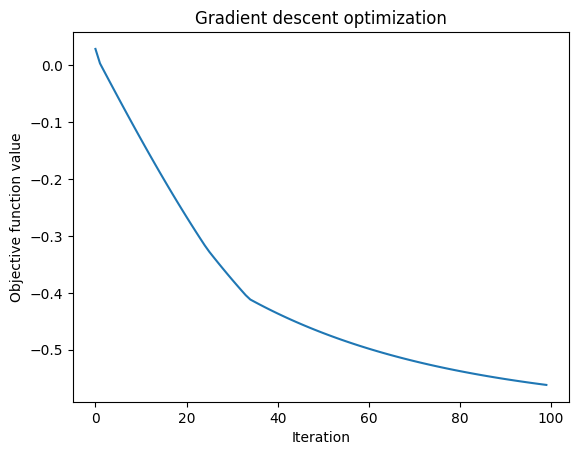

In [ ]:
# Define the learning rate
alpha = 0.01

# Define the initial weights
weights = np.array([0.1, 0.2, 0.3, 0.1, 0.2, 0.1, 0.1])

# Define the number of iterations
iterations = 100

# Define a list to store the objective function values
obj_values = []

# Loop over the iterations
for i in range(iterations):
    # Calculate the objective function value
    obj_value = objective_function(weights)
    # Append the objective function value to the list
    obj_values.append(obj_value)
    # Print the iteration number and the objective function value
    print(f"Iteration {i+1}: Objective function value = {obj_value:.4f}")
    # Calculate the gradient
    grad = gradient(weights)
    # Update the weights using the gradient and the learning rate
    weights = weights - alpha * grad
    # Apply the box constraint to the weights
    weights = np.clip(weights, 0, 1)
    # Apply the budget constraint to the weights
    weights = weights / weights.sum()

# Print the optimal weights
print(f"Optimal weights: {weights}")

# Plot the objective function values
import matplotlib.pyplot as plt
plt.plot(obj_values)
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.title("Gradient descent optimization")
plt.show()

In [ ]:
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy

# get daily data from yfinance
def get_daily_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    # data = nsepy.get_history(symbol=symbol, start=start, end=end)
    return data

# calculate the maximum drawdown for each stock
def max_drawdown(data):
    # calculate the cumulative return
    data['cum_return'] = (1 + data['bnh_returns']).cumprod()
    # calculate the previous peak
    data['peak'] = data['cum_return'].cummax()
    # calculate the drawdown
    data['drawdown'] = data['cum_return'] / data['peak'] - 1
    # calculate the maximum drawdown
    data['max_drawdown'] = data['drawdown'].cummin()
    # return the maximum drawdown
    return data['max_drawdown']

# calculate the Bollinger Bands breakout for each stock
def bb_breakout(data, window, std):
    # calculate the 20-day moving average
    data['ma'] = data['Close'].rolling(window).mean()
    # calculate the 20-day standard deviation
    data['std'] = data['Close'].rolling(window).std()
    # calculate the upper and lower bands
    data['upper'] = data['ma'] + std * data['std']
    data['lower'] = data['ma'] - std * data['std']
    # calculate the breakout signals
    data['buy'] = np.where(data['Close'] > data['upper'], 1, 0)
    data['sell'] = np.where(data['Close'] < data['lower'], -1, 0)
    # return the breakout signals
    return data['buy'], data['sell']
#Define the function to calculate the cumulative return
def get_cumulative_return(returns):
    # Calculate the cumulative product of the returns
    cumprod = (1 + returns).cumprod()
    # Return the last value of the cumulative product
    return cumprod.iloc[-1]
# Define the function to calculate the annualized sharpe ratio
def get_annualized_sharpe_ratio(returns):
    # Calculate the annualized return
    annualized_return = (1 + returns).cumprod().iloc[-1] ** (252 / len(returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    # Calculate the sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    # Return the sharpe ratio
    return sharpe_ratio
# backtesting parameters
days = 2000
end = dt.today()
start = end - pd.Timedelta(days=days)

# portfolio of stocks
portfolio_stocks = ["COST","AMZN","GOOG","AXP","MSFT","MMM"]

# defining a data frame to store portfolio returns
portfolio_strategy_returns = pd.DataFrame()
portfolio_bnh_returns = pd.DataFrame()

# buy and hold returns for individual stocs
bnh_stock_returns = []
bnh_stock_sharpe = []

# iterating over stocks in the portfolio
for stock in portfolio_stocks:
    data = get_daily_data(stock, start, end)

    # Calcuulating daily returns
    data["bnh_returns"] = np.log(data["Close"]/data["Close"].shift())

    # Calculating maximum drawdown
    data['max_drawdown'] = max_drawdown(data)

    # Calculating Bollinger Bands breakout
    data['buy'], data['sell'] = bb_breakout(data, window=20, std=2)

    # Defining the risk-reward ratio
    rr = 2

    # Calculating the mean return
    data['mean_return'] = data['bnh_returns'].rolling(20).mean()

    # Defining the exit signal based on the maximum drawdown and the risk-reward ratio
    data['exit'] = np.where(data['max_drawdown'] < -rr * data['mean_return'], -1, 0)

    # Combining the buy, sell, and exit signals
    data['signal'] = data['buy'] + data['sell'] + data['exit']

    # Calculating the strategy returns
    data['strategy_returns'] = data['bnh_returns'] * data['signal']

    # Storing the strategy returns in the portfolio data frame
    portfolio_strategy_returns[stock] = data['strategy_returns']

    # Calculating the cumulative and annualized sharpe ratio for each stock
    bnh_stock_returns.append(get_cumulative_return(data['strategy_returns']))
    bnh_stock_sharpe.append(get_annualized_sharpe_ratio(data['strategy_returns']))

    # Creating a performance data frame
    perf = pd.DataFrame(index=portfolio_stocks,columns=["Cumulative returns","Annualized Sharpe Ratio"])

# Assigning the performance metrics to the data frame
for i,stock in enumerate(portfolio_stocks):
    cum_ret = bnh_stock_returns[i]
    anu_shp = bnh_stock_sharpe[i]
    perf.loc[stock] = [cum_ret,anu_shp]

# Printing the performance data frame
print(perf)
# Define the weights for each stock
weights = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1,0.1]

# Multiply the returns by the weights and sum them along the columns
portfolio_strategy_returns['Portfolio_rets'] = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)

# Printing the portfolio performance metrics
print("Cumulative returns BB Blackout                 :",get_cumulative_return(portfolio_strategy_returns["Portfolio_rets"]))
print("Annualized sharpe ratio BB Strategy             :",get_annualized_sharpe_ratio(portfolio_strategy_returns["Portfolio_rets"]))
print("\n")

# Plotting the portfolio cumulative returns
colors = ['m', 'g', 'r', 'c', 'm', 'y', 'b']
portfolio_strategy_returns.cumsum().plot(figsize=(16,10), title="BB Blackout STRATEGY CUMULATIVE RETURNS", color=colors)
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy

# get daily data from yfinance
def get_daily_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    # data = nsepy.get_history(symbol=symbol, start=start, end=end)
    return data

# calculate the maximum drawdown for each stock
def max_drawdown(data):
    # calculate the cumulative return
    data['cum_return'] = (1 + data['bnh_returns']).cumprod()
    # calculate the previous peak
    data['peak'] = data['cum_return'].cummax()
    # calculate the drawdown
    data['drawdown'] = data['cum_return'] / data['peak'] - 1
    # calculate the maximum drawdown
    data['max_drawdown'] = data['drawdown'].cummin()
    # return the maximum drawdown
    return data['max_drawdown']

# calculate the stochastic oscillator for each stock
def get_stoch(high, low, close):
    # calculate the highest high and lowest low over a 14-day period
    highest_high = high.rolling(14).max()
    lowest_low = low.rolling(14).min()
    # calculate the fast stochastic line
    stoch_fast = (close - lowest_low) / (highest_high - lowest_low) * 100
    # calculate the slow stochastic line as the 3-day simple moving average of the fast line
    stoch_slow = stoch_fast.rolling(3).mean()
    # return the fast and slow stochastic lines
    return stoch_fast, stoch_slow

#Define the function to calculate the cumulative return
def get_cumulative_return(returns):
    # Calculate the cumulative product of the returns
    cumprod = (1 + returns).cumprod()
    # Return the last value of the cumulative product
    return cumprod.iloc[-1]

# Define the function to calculate the annualized sharpe ratio
def get_annualized_sharpe_ratio(returns):
    # Calculate the annualized return
    annualized_return = (1 + returns).cumprod().iloc[-1] ** (252 / len(returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    # Calculate the sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    # Return the sharpe ratio
    return sharpe_ratio

# backtesting parameters
days = 2000
end = dt.today()
start = end - pd.Timedelta(days=days)

# portfolio of stocks
portfolio_stocks = ["COST","AMZN","GOOG","AXP","MSFT","MMM"]

# defining a data frame to store portfolio returns
portfolio_strategy_returns = pd.DataFrame()
portfolio_bnh_returns = pd.DataFrame()

# buy and hold returns for individual stocs
bnh_stock_returns = []
bnh_stock_sharpe = []

# iterating over stocks in the portfolio
for stock in portfolio_stocks:
    data = get_daily_data(stock, start, end)

    # Calcuulating daily returns
    data["bnh_returns"] = np.log(data["Close"]/data["Close"].shift())

    # Calculating maximum drawdown
    data['max_drawdown'] = max_drawdown(data)

    # Calculating stochastic oscillator
    data['stoch_fast'], data['stoch_slow'] = get_stoch(data['High'], data['Low'], data['Close'])

    # Defining the risk-reward ratio
    rr = 2

    # Calculating the mean return
    data['mean_return'] = data['bnh_returns'].rolling(20).mean()

    # Defining the exit signal based on the maximum drawdown and the risk-reward ratio
    data['exit'] = np.where(data['max_drawdown'] < -rr * data['mean_return'], -1, 0)

    # Calculating the buy and sell signals based on the stochastic oscillator
    data['buy'] = np.where((data['stoch_slow'] > data['stoch_fast']) & (data['stoch_slow'].shift() < data['stoch_fast'].shift()), 1, 0)
    data['sell'] = np.where((data['stoch_slow'] < data['stoch_fast']) & (data['stoch_slow'].shift() > data['stoch_fast'].shift()), -1, 0)

    # Combining the buy, sell, and exit signals
    data['signal'] = data['buy'] + data['sell'] + data['exit']

    # Calculating the strategy returns
    data['strategy_returns'] = data['bnh_returns'] * data['signal']

    # Storing the strategy returns in the portfolio data frame
    portfolio_strategy_returns[stock] = data['strategy_returns']

    # Calculating the cumulative and annualized sharpe ratio for each stock
    bnh_stock_returns.append(get_cumulative_return(data['strategy_returns']))
    bnh_stock_sharpe.append(get_annualized_sharpe_ratio(data['strategy_returns']))

    # Creating a performance data frame
    perf = pd.DataFrame(index=portfolio_stocks,columns=["Cumulative returns","Annualized Sharpe Ratio"])

# Assigning the performance metrics to the data frame
for i,stock in enumerate(portfolio_stocks):
    cum_ret = bnh_stock_returns[i]
    anu_shp = bnh_stock_sharpe[i]
    perf.loc[stock] = [cum_ret,anu_shp]

# Printing the performance data frame
print(perf)
# Define the weights for each stock
weights = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1,0.1]

# Multiply the returns by the weights and sum them along the columns
portfolio_strategy_returns['Portfolio_rets'] = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)

# Printing the portfolio performance metrics
print("Cumulative returns Stochastic Oscillator                 :",get_cumulative_return(portfolio_strategy_returns["Portfolio_rets"]))
print("Annualized sharpe ratio Stochastic Oscillator             :",get_annualized_sharpe_ratio(portfolio_strategy_returns["Portfolio_rets"]))
print("\n")

# Plotting the portfolio cumulative returns
colors = ['m', 'g', 'r', 'c', 'm', 'y', 'b']
portfolio_strategy_returns.cumsum().plot(figsize=(16,10), title="Stochastic Oscillator STRATEGY CUMULATIVE RETURNS", color=colors)
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy

# get daily data from yfinance
def get_daily_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    # data = nsepy.get_history(symbol=symbol, start=start, end=end)
    return data

# calculate the maximum drawdown for each stock
def max_drawdown(data):
    # calculate the cumulative return
    data['cum_return'] = (1 + data['bnh_returns']).cumprod()
    # calculate the previous peak
    data['peak'] = data['cum_return'].cummax()
    # calculate the drawdown
    data['drawdown'] = data['cum_return'] / data['peak'] - 1
    # calculate the maximum drawdown
    data['max_drawdown'] = data['drawdown'].cummin()
    # return the maximum drawdown
    return data['max_drawdown']

# calculate the moving average crossover for each stock
def get_mac(close, short_window, long_window):
    # calculate the short-term and long-term moving averages
    ma_short = close.rolling(short_window).mean()
    ma_long = close.rolling(long_window).mean()
    # return the moving averages
    return ma_short, ma_long

#Define the function to calculate the cumulative return
def get_cumulative_return(returns):
    # Calculate the cumulative product of the returns
    cumprod = (1 + returns).cumprod()
    # Return the last value of the cumulative product
    return cumprod.iloc[-1]

# Define the function to calculate the annualized sharpe ratio
def get_annualized_sharpe_ratio(returns):
    # Calculate the annualized return
    annualized_return = (1 + returns).cumprod().iloc[-1] ** (252 / len(returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    # Calculate the sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    # Return the sharpe ratio
    return sharpe_ratio

# backtesting parameters
days = 2000
end = dt.today()
start = end - pd.Timedelta(days=days)

# portfolio of stocks
portfolio_stocks = ["COST","AMZN","GOOG","AXP","MSFT","MMM"]

# defining a data frame to store portfolio returns
portfolio_strategy_returns = pd.DataFrame()
portfolio_bnh_returns = pd.DataFrame()

# buy and hold returns for individual stocs
bnh_stock_returns = []
bnh_stock_sharpe = []

# iterating over stocks in the portfolio
for stock in portfolio_stocks:
    data = get_daily_data(stock, start, end)

    # Calcuulating daily returns
    data["bnh_returns"] = np.log(data["Close"]/data["Close"].shift())

    # Calculating maximum drawdown
    data['max_drawdown'] = max_drawdown(data)

    # Calculating moving average crossover
    data['ma_short'], data['ma_long'] = get_mac(data['Close'], short_window=5, long_window=20)

    # Defining the risk-reward ratio
    rr = 2

    # Calculating the mean return
    data['mean_return'] = data['bnh_returns'].rolling(20).mean()

    # Defining the exit signal based on the maximum drawdown and the risk-reward ratio
    data['exit'] = np.where(data['max_drawdown'] < -rr * data['mean_return'], -1, 0)

    # Calculating the buy and sell signals based on the moving average crossover
    data['buy'] = np.where((data['ma_short'] > data['ma_long']) & (data['ma_short'].shift() < data['ma_long'].shift()), 1, 0)
    data['sell'] = np.where((data['ma_short'] < data['ma_long']) & (data['ma_short'].shift() > data['ma_long'].shift()), -1, 0)

    # Combining the buy, sell, and exit signals
    data['signal'] = data['buy'] + data['sell'] + data['exit']

    # Calculating the strategy returns
    data['strategy_returns'] = data['bnh_returns'] * data['signal']

    # Storing the strategy returns in the portfolio data frame
    portfolio_strategy_returns[stock] = data['strategy_returns']

    # Calculating the cumulative and annualized sharpe ratio for each stock
    bnh_stock_returns.append(get_cumulative_return(data['strategy_returns']))
    bnh_stock_sharpe.append(get_annualized_sharpe_ratio(data['strategy_returns']))

    # Creating a performance data frame
    perf = pd.DataFrame(index=portfolio_stocks,columns=["Cumulative returns","Annualized Sharpe Ratio"])

# Assigning the performance metrics to the data frame
for i,stock in enumerate(portfolio_stocks):
    cum_ret = bnh_stock_returns[i]
    anu_shp = bnh_stock_sharpe[i]
    perf.loc[stock] = [cum_ret,anu_shp]

# Printing the performance data frame
print(perf)
# Define the weights for each stock
weights = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1,0.1]

# Multiply the returns by the weights and sum them along the columns
portfolio_strategy_returns['Portfolio_rets'] = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)

# Printing the portfolio performance metrics
print("Cumulative returns Moving Average Crossover                 :",get_cumulative_return(portfolio_strategy_returns["Portfolio_rets"]))
print("Annualized sharpe ratio Moving Average Crossover             :",get_annualized_sharpe_ratio(portfolio_strategy_returns["Portfolio_rets"]))
print("\n")

# Plotting the portfolio cumulative returns
colors = ['m', 'g', 'r', 'c', 'm', 'y', 'b']
portfolio_strategy_returns.cumsum().plot(figsize=(16,10), title="Moving Average Crossover STRATEGY CUMULATIVE RETURNS", color=colors)
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy

# get daily data from yfinance
def get_daily_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    # data = nsepy.get_history(symbol=symbol, start=start, end=end)
    return data

# calculate the maximum drawdown for each stock
def max_drawdown(data):
    # calculate the cumulative return
    data['cum_return'] = (1 + data['bnh_returns']).cumprod()
    # calculate the previous peak
    data['peak'] = data['cum_return'].cummax()
    # calculate the drawdown
    data['drawdown'] = data['cum_return'] / data['peak'] - 1
    # calculate the maximum drawdown
    data['max_drawdown'] = data['drawdown'].cummin()
    # return the maximum drawdown
    return data['max_drawdown']

# define a function to calculate the exponential moving average of a series
def ema(series, period):
    # use the pandas ewm function with adjust=False
    return series.ewm(span=period, adjust=False).mean()

# calculate the MACD histogram for each stock
def macd_histogram(data, fast, slow, signal):
    # calculate the 12-day, 26-day, and 9-day exponential moving averages of the closing prices
    ema_fast = ema(data['Close'], fast)
    ema_slow = ema(data['Close'], slow)
    ema_signal = ema(data['Close'], signal)
    # calculate the MACD line as the difference between the 12-day and 26-day exponential moving averages
    data['macd'] = ema_fast - ema_slow
    # calculate the signal line as the 9-day exponential moving average of the MACD line
    data['signal'] = ema(data['macd'], signal)
    # calculate the histogram as the difference between the MACD line and the signal line
    data['histogram'] = data['macd'] - data['signal']
    # calculate the buy and sell signals based on the MACD histogram
    data['buy'] = np.where((data['histogram'] > 0) & (data['histogram'] > data['histogram'].shift()), 1, 0)
    data['sell'] = np.where((data['histogram'] < 0) & (data['histogram'] < data['histogram'].shift()), -1, 0)
    # return the buy and sell signals
    return data['buy'], data['sell']

#Define the function to calculate the cumulative return
def get_cumulative_return(returns):
    # Calculate the cumulative product of the returns
    cumprod = (1 + returns).cumprod()
    # Return the last value of the cumulative product
    return cumprod.iloc[-1]

# Define the function to calculate the annualized sharpe ratio
def get_annualized_sharpe_ratio(returns):
    # Calculate the annualized return
    annualized_return = (1 + returns).cumprod().iloc[-1] ** (252 / len(returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    # Calculate the sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    # Return the sharpe ratio
    return sharpe_ratio

# backtesting parameters
days = 2000
end = dt.today()
start = end - pd.Timedelta(days=days)

# portfolio of stocks
portfolio_stocks = ["COST","AMZN","GOOG","AXP","MSFT","MMM"]

# defining a data frame to store portfolio returns
portfolio_strategy_returns = pd.DataFrame()
portfolio_bnh_returns = pd.DataFrame()

# buy and hold returns for individual stocs
bnh_stock_returns = []
bnh_stock_sharpe = []

# iterating over stocks in the portfolio
for stock in portfolio_stocks:
    data = get_daily_data(stock, start, end)

    # Calcuulating daily returns
    data["bnh_returns"] = np.log(data["Close"]/data["Close"].shift())

    # Calculating maximum drawdown
    data['max_drawdown'] = max_drawdown(data)

    # Calculating MACD histogram
    data['buy'], data['sell'] = macd_histogram(data, fast=12, slow=26, signal=9)

    # Defining the risk-reward ratio
    rr = 2

    # Calculating the mean return
    data['mean_return'] = data['bnh_returns'].rolling(20).mean()

    # Defining the exit signal based on the maximum drawdown and the risk-reward ratio
    data['exit'] = np.where(data['max_drawdown'] < -rr * data['mean_return'], -1, 0)

    # Combining the buy, sell, and exit signals
    data['signal'] = data['buy'] + data['sell'] + data['exit']

    # Calculating the strategy returns
    data['strategy_returns'] = data['bnh_returns'] * data['signal']

    # Storing the strategy returns in the portfolio data frame
    portfolio_strategy_returns[stock] = data['strategy_returns']

    # Calculating the cumulative and annualized sharpe ratio for each stock
    bnh_stock_returns.append(get_cumulative_return(data['strategy_returns']))
    bnh_stock_sharpe.append(get_annualized_sharpe_ratio(data['strategy_returns']))

    # Creating a performance data frame
    perf = pd.DataFrame(index=portfolio_stocks,columns=["Cumulative returns","Annualized Sharpe Ratio"])

# Assigning the performance metrics to the data frame
for i,stock in enumerate(portfolio_stocks):
    cum_ret = bnh_stock_returns[i]
    anu_shp = bnh_stock_sharpe[i]
    perf.loc[stock] = [cum_ret,anu_shp]

# Printing the performance data frame
print(perf)
# Define the weights for each stock
weights = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1,0.1]

# Multiply the returns by the weights and sum them along the columns
portfolio_strategy_returns['Portfolio_rets'] = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)

# Printing the portfolio performance metrics
print("Cumulative returns MACD Histogram                 :",get_cumulative_return(portfolio_strategy_returns["Portfolio_rets"]))
print("Annualized sharpe ratio MACD Histogram             :",get_annualized_sharpe_ratio(portfolio_strategy_returns["Portfolio_rets"]))
print("\n")

# Plotting the portfolio cumulative returns
colors = ['m', 'g', 'r', 'c', 'm', 'y', 'b']
portfolio_strategy_returns.cumsum().plot(figsize=(16,10), title="MACD Histogram STRATEGY CUMULATIVE RETURNS", color=colors)
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy

# get daily data from yfinance
def get_daily_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    # data = nsepy.get_history(symbol=symbol, start=start, end=end)
    return data

# calculate the maximum drawdown for each stock
def max_drawdown(data):
    # calculate the cumulative return
    data['cum_return'] = (1 + data['bnh_returns']).cumprod()
    # calculate the previous peak
    data['peak'] = data['cum_return'].cummax()
    # calculate the drawdown
    data['drawdown'] = data['cum_return'] / data['peak'] - 1
    # calculate the maximum drawdown
    data['max_drawdown'] = data['drawdown'].cummin()
    # return the maximum drawdown
    return data['max_drawdown']

# calculate the RSI divergence for each stock
def rsi_divergence(data, period, fast, slow):
    # calculate the difference between the closing prices of consecutive days
    delta = data['Close'].diff()
    # separate the positive and negative differences
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    # calculate the exponential moving average of the positive and negative differences
    up_ema = up.ewm(com=period-1, adjust=False).mean()
    down_ema = down.ewm(com=period-1, adjust=False).mean()
    # calculate the relative strength as the ratio of the positive and negative averages
    rs = up_ema / down_ema
    # calculate the RSI as 100 minus 100 divided by 1 plus the relative strength
    rsi = 100 - (100 / (1 + rs))
    # calculate the fast and slow RSI
    rsi_fast = rsi.rolling(fast).mean()
    rsi_slow = rsi.rolling(slow).mean()
    # calculate the divergence as the difference between the fast and slow RSI
    divergence = rsi_fast - rsi_slow
    # calculate the buy and sell signals based on the RSI divergence
    data['buy'] = np.where((rsi < 30) & (divergence > divergence.shift()), 1, 0)
    data['sell'] = np.where((rsi > 70) & (divergence < divergence.shift()), -1, 0)
    # return the buy and sell signals
    return data['buy'], data['sell']

#Define the function to calculate the cumulative return
def get_cumulative_return(returns):
    # Calculate the cumulative product of the returns
    cumprod = (1 + returns).cumprod()
    # Return the last value of the cumulative product
    return cumprod.iloc[-1]

# Define the function to calculate the annualized sharpe ratio
def get_annualized_sharpe_ratio(returns):
    # Calculate the annualized return
    annualized_return = (1 + returns).cumprod().iloc[-1] ** (252 / len(returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = returns.std() * (252 ** 0.5)
    # Calculate the sharpe ratio
    sharpe_ratio = annualized_return / annualized_volatility
    # Return the sharpe ratio
    return sharpe_ratio

# backtesting parameters
days = 2000
end = dt.today()
start = end - pd.Timedelta(days=days)

# portfolio of stocks
portfolio_stocks = ["COST","AMZN","GOOG","AXP","MSFT","MMM"]

# defining a data frame to store portfolio returns
portfolio_strategy_returns = pd.DataFrame()
portfolio_bnh_returns = pd.DataFrame()

# buy and hold returns for individual stocs
bnh_stock_returns = []
bnh_stock_sharpe = []

# iterating over stocks in the portfolio
for stock in portfolio_stocks:
    data = get_daily_data(stock, start, end)

    # Calcuulating daily returns
    data["bnh_returns"] = np.log(data["Close"]/data["Close"].shift())

    # Calculating maximum drawdown
    data['max_drawdown'] = max_drawdown(data)

    # Calculating RSI divergence
    data['buy'], data['sell'] = rsi_divergence(data, period=14, fast=5, slow=14)

    # Defining the risk-reward ratio
    rr = 2

    # Calculating the mean return
    data['mean_return'] = data['bnh_returns'].rolling(20).mean()

    # Defining the exit signal based on the maximum drawdown and the risk-reward ratio
    data['exit'] = np.where(data['max_drawdown'] < -rr * data['mean_return'], -1, 0)

    # Combining the buy, sell, and exit signals
    data['signal'] = data['buy'] + data['sell'] + data['exit']

    # Calculating the strategy returns
    data['strategy_returns'] = data['bnh_returns'] * data['signal']

    # Storing the strategy returns in the portfolio data frame
    portfolio_strategy_returns[stock] = data['strategy_returns']

    # Calculating the cumulative and annualized sharpe ratio for each stock
    bnh_stock_returns.append(get_cumulative_return(data['strategy_returns']))
    bnh_stock_sharpe.append(get_annualized_sharpe_ratio(data['strategy_returns']))

    # Creating a performance data frame
    perf = pd.DataFrame(index=portfolio_stocks,columns=["Cumulative returns","Annualized Sharpe Ratio"])

# Assigning the performance metrics to the data frame
for i,stock in enumerate(portfolio_stocks):
    cum_ret = bnh_stock_returns[i]
    anu_shp = bnh_stock_sharpe[i]
    perf.loc[stock] = [cum_ret,anu_shp]

# Printing the performance data frame
print(perf)
# Define the weights for each stock
weights = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1,0.1]

# Multiply the returns by the weights and sum them along the columns
portfolio_strategy_returns['Portfolio_rets'] = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)

# Printing the portfolio performance metrics
print("Cumulative returns RSI Divergence                 :",get_cumulative_return(portfolio_strategy_returns["Portfolio_rets"]))
print("Annualized sharpe ratio RSI Divergence             :",get_annualized_sharpe_ratio(portfolio_strategy_returns["Portfolio_rets"]))
print("\n")

# Plotting the portfolio cumulative returns
colors = ['m', 'g', 'r', 'c', 'm', 'y', 'b']
portfolio_strategy_returns.cumsum().plot(figsize=(16,10), title="RSI Divergence STRATEGY CUMULATIVE RETURNS", color=colors)

In [ ]:

# Define the objective function as the negative of the annualized Sharpe ratio
def objective_function(weights):
    # Calculate the portfolio returns
    portfolio_returns = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)
    # Calculate the negative of the annualized Sharpe ratio
    neg_sharpe = -get_annualized_sharpe_ratio(portfolio_returns)
    # Return the negative of the annualized Sharpe ratio
    return neg_sharpe

# Define the gradient of the objective function
def gradient(weights):
    # Calculate the portfolio returns
    portfolio_returns = portfolio_strategy_returns.mul(weights, axis=1).sum(axis=1)
    # Calculate the annualized return
    annualized_return = (1 + portfolio_returns).cumprod().iloc[-1] ** (252 / len(portfolio_returns)) - 1
    # Calculate the annualized volatility
    annualized_volatility = portfolio_returns.std() * (252 ** 0.5)
    # Calculate the gradient of the annualized return
    grad_return = portfolio_strategy_returns.mean() * 252
    # Calculate the gradient of the annualized volatility
    grad_volatility = portfolio_strategy_returns.cov() @ weights * (252 ** 0.5)
    # Calculate the gradient of the Sharpe ratio
    grad_sharpe = (grad_return / annualized_volatility) - (annualized_return / annualized_volatility ** 2) * grad_volatility
    # Return the negative of the gradient of the Sharpe ratio
    return -grad_shar